In [1]:
%matplotlib inline

In [2]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm 

### Helper functions

In [3]:
def read_data(file_name, has_header):
    f = open(file_name, 'r')
    if has_header:
        header = re.sub('["\n]', '', f.readline()).split(' ')
    matrix = []
    data = []
    for line in f:
        items = line.split(' ')
        if len(items) > 1:
            matrix.append(items[0])
            del items[0]
            data.append(list(map(float, items)))
    if has_header:
        return (matrix, np.asmatrix(data), header)
    else:
        return matix, np.asmatrix(data)

In [4]:
def calc_avg_data(prefix, suffix ,files):
    avg_data = None
    for f in files:
        matrix, data, header = read_data(prefix + f + suffix, True)
        if avg_data is None:
            avg_data = data
        else:
            avg_data = avg_data + data
    avg_data = avg_data / len(files)
    return matrix, avg_data, header

In [5]:
def plot_relative_values(matrix, data, header):
    relative_data = data / data.max(1)
    fig = plt.figure(figsize = (400,data.shape[1]))
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0])
    ax.set_yticks(range(data.shape[1]))
    ax.set_yticklabels(header[1:(data.shape[1]+1)])
    ax.set_xticks([i for i in range(len(matrix))])
    ax.set_xticklabels(matrix, rotation=45, ha="right")
    plt.imshow(relative_data.T, interpolation='nearest', cmap="OrRd_r")
    plt.colorbar()
    plt.show()

In [6]:
def plot_statistics(matrix, data, header):
    fig = plt.figure(figsize = (444,24))
    for i in range(0, 24, 1):
        ax = plt.subplot(24, 1, i+1)
        ax.set_yticks([0])
        ax.set_yticklabels([header[i+1]])
        if i == 23:
            ax.set_xticks(range(len(matrix)))
            ax.set_xticklabels(matrix, rotation=45, ha="right")
        else:
            ax.get_xaxis().set_visible(False) 
        plt.imshow(data.T[i-1,:], interpolation='nearest', cmap="OrRd_r")
        plt.colorbar()

    plt.show()

### Visualization of matrix vector multiplication runtime, format conversion runtime and matrix statistics

In [7]:
files = ["25615", "391750", "494030", "497461", "643522", "674742", "685203", "810763", "867607", "872897"]

In [8]:
matrix_matvec, avg_data_matvec, header_matvec = calc_avg_data("../stats/MatVecMultStats_", ".txt", files)

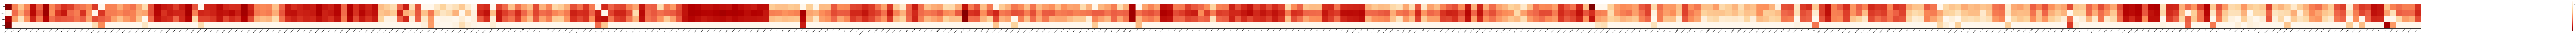

In [9]:
plot_relative_values(matrix_matvec, avg_data_matvec, header_matvec)

In [10]:
matrix_convert, avg_data_convert, header_convert = calc_avg_data("../stats/MatVecConvertStats_", ".txt", files)

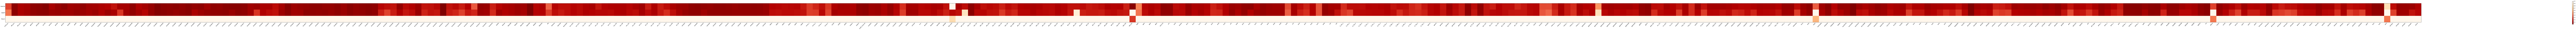

In [11]:
plot_relative_values(matrix_convert, avg_data_convert, header_convert)

In [12]:
matrix_stats, avg_data_stats, header_stats = calc_avg_data("../stats/MtxStats_", ".txt", files)

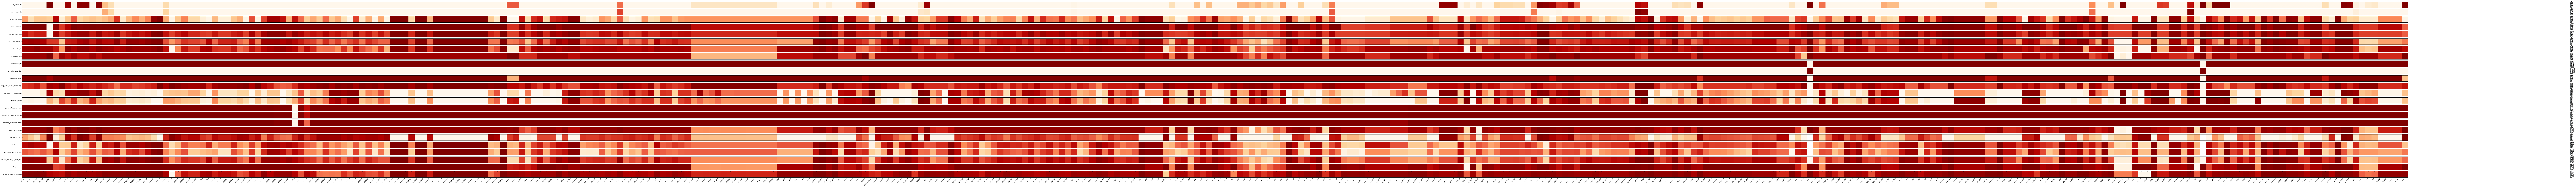

In [13]:
plot_statistics(matrix_stats, avg_data_stats, header_stats)

### Investigating performance improvements on using different formats

In [14]:
print "Total time in nanoseconds for executing the matrix vector multiplication (all test matrices) in CSR format only"
total_csr = avg_data_matvec[:,0].sum()
total_csr

Total time in nanoseconds for executing the matrix vector multiplication (all test matrices) in CSR format only


3850490.8999999999

In [15]:
print "Total time in nanoseconds for executing the matrix vector multiplication (all test matrices) in the fastest format always"
total_best = avg_data_matvec.min(1).sum()
total_best

Total time in nanoseconds for executing the matrix vector multiplication (all test matrices) in the fastest format always


2538347.3000000003

In [16]:
print "Performance increase (speedup)"
total_csr / total_best

Performance increase (speedup)


1.5169283178862087

In [17]:
#indices of the best format
indices = avg_data_matvec.argmin(1).A1
#conversion time from CSR to the best format (0 when CSR is best Format)
convert_time = avg_data_convert[range(avg_data_convert.shape[0]), indices-1].A1
convert_time[indices == 0] = 0
print "Total conversion time in nanoseconds when using best multiplication format"
convert_time.sum()

Total conversion time in nanoseconds when using best multiplication format


6069641.0

In [18]:
print "Performace decrease when adding conversion time to multiplication time (speedup)"
total_csr / (total_best + convert_time.sum())

Performace decrease when adding conversion time to multiplication time (speedup)


0.44731600065023319

### Investigating influence of matrix statistics on multiplication runtime of different formats (using linear regression)

In [19]:
Y = avg_data_matvec / np.linalg.norm(avg_data_matvec)

In [20]:
Y_header = header_matvec
del Y_header[0]

In [21]:
df_Y = pd.DataFrame(Y, columns = Y_header)

In [22]:
norm_x = np.ones_like(avg_data_stats)

for i in range(avg_data_stats.shape[1]):
    norm_x[:, i] = avg_data_stats[:, i] / np.linalg.norm(avg_data_stats[:, i])

X = sm.add_constant(norm_x)

In [23]:
X_header = header_stats
X_header[0] = "const"
df_X = pd.DataFrame(X, columns = X_header)

In [24]:
#removing statistics that cause linear regression to fail (they have NaN elements)
del df_X[X_header[20]]
del df_X[X_header[19]]
del df_X[X_header[18]]
X = np.delete(X, 20, axis=1)
X = np.delete(X, 19, axis=1)
X = np.delete(X, 18, axis=1)

In [25]:
model = sm.OLS(df_Y['CSR'], df_X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                    CSR   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     2.037
Date:                Sun, 13 Sep 2015   Prob (F-statistic):            0.00486
Time:                        14:50:23   Log-Likelihood:                 1113.6
No. Observations:                 389   AIC:                            -2183.
Df Residuals:                     367   BIC:                            -2096.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const           

In [26]:
model = sm.OLS(df_Y['ModCSR'], df_X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                 ModCSR   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.037
Method:                 Least Squares   F-statistic:                    0.3382
Date:                Sun, 13 Sep 2015   Prob (F-statistic):              0.998
Time:                        14:50:23   Log-Likelihood:                 749.41
No. Observations:                 389   AIC:                            -1455.
Df Residuals:                     367   BIC:                            -1368.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const           

In [27]:
model = sm.OLS(df_Y['Jagged'], df_X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                 Jagged   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     1.881
Date:                Sun, 13 Sep 2015   Prob (F-statistic):             0.0113
Time:                        14:50:23   Log-Likelihood:                 946.16
No. Observations:                 389   AIC:                            -1848.
Df Residuals:                     367   BIC:                            -1761.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const           

In [28]:
model = sm.OLS(df_Y['Ellpack'], df_X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                Ellpack   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1.633
Date:                Sun, 13 Sep 2015   Prob (F-statistic):             0.0398
Time:                        14:50:23   Log-Likelihood:                 967.08
No. Observations:                 389   AIC:                            -1890.
Df Residuals:                     367   BIC:                            -1803.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const           